### Linear Regression - Interpreting the result
In this notebook we use linear regression to predict the coefficients corresponding to the top eigenvectors of the measurements:
* TAVG: The average temperature for day/location. (TMAX + TMIN)/2
* TRANGE: The temperature range between the highest and lowest temperatures of the day. TMAX-TMIN.
* SNWD: The depth of the accumulated snow.

These 9 variables are the output variables that we aim to predict.

The 4 input variables we use for the regression are properties of the location of the station:
* latitude, longitude: location of the station.
* elevation: the elevation of the location above sea level.
* dist_coast: the distance of the station from the coast (in kilometers).


### Read and parse the data

In [1]:
# Name: Kishan Kumar Sachdeva 
# Email: ksachdev@ucsd.edu  
# PID: A53104678
import pickle
import pandas as pd
!ls *.pickle  # check 

stations_projections.pickle


In [2]:
!curl -o "stations_projections.pickle" "http://mas-dse-open.s3.amazonaws.com/Weather/stations_projections.pickle"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2750k  100 2750k    0     0  1512k      0  0:00:01  0:00:01 --:--:-- 1512k


In [11]:
data = pickle.load(open("stations_projections.pickle",'r'))
data.shape

(12140, 8)

In [12]:
data.head(1)

,station,TAVG_coeff,TRANGE_coeff,SNWD_coeff,latitude,longitude,elevation,dist_coast
0,USC00044534,"[3047.96236332, 1974.34852034, 150.560792408]","[-2903.63287861, -236.907267527, 147.021790682]","[0.19150300062, 0.187262808215, -0.0401379552536]",36.0042,-119.96,73.2,107.655


In [13]:
# break up the lists of coefficients separate columns
for col in [u'TAVG_coeff', u'TRANGE_coeff', u'SNWD_coeff']:
    for i in range(3):
        new_col=col+str(i+1)
        data[new_col]=[e[i] for e in list(data[col])]
    data.drop(labels=col,axis=1,inplace=True)
data.drop(labels='station',axis=1,inplace=True)
data.head(1)

,latitude,longitude,elevation,dist_coast,TAVG_coeff1,TAVG_coeff2,TAVG_coeff3,TRANGE_coeff1,TRANGE_coeff2,TRANGE_coeff3,SNWD_coeff1,SNWD_coeff2,SNWD_coeff3
0,36.0042,-119.96,73.2,107.655,3047.962363,1974.34852,150.560792,-2903.632879,-236.907268,147.021791,0.191503,0.187263,-0.040138


### Performing and evaluating the regression
As the size of the data is modest, we can perform the regression using regular python (not spark) running on a laptop. We use the library `sklearn`

In [14]:
from sklearn.linear_model import LinearRegression

### Coefficient of determination

Computed by calling the method `LinearRegression.score()`

The regression score comes under several names: "Coefficient of determination", $R^2$, "R squared score", "percentage of variance explained", "correlation coefficient". It is explained in more detail in [wikipedia](https://en.wikipedia.org/wiki/Coefficient_of_determination).

Roughly speaking the $R^2$-score measures the fraction of the variance of the regression output variable that is explained by the prediction function. The score varies between 0 and 1. A score of 1 means that the regression function perfectly predicts the value of $y$. A score of 0 means that it does not predict $y$ at all.

#### Training score vs Test score
Suppose we fit a regression function with 10 features to 10 data points. We are very likely to fit the data perfectly and get a score of 1. However, this does not mean that our model truly explains the data. It just means that the number of training examples we are using to fit the model is too small. To detect this situation, we can compute the score of the model that was fit to the **training set**, on a **test set**. If the ratio between the test score and the training score is smaller than, say, 0.1, then our regression function probably over-fits the data.

#### Finding the importance of input variables
The fact that a regression coefficient is far from zero provides some indication that it is important. However, the size of these coefficients also depends on the scaling of the variables. A much more reliable way to find out which of the input variables are important is to compare the score of the regression function we get when using all of the input variables to the score when one of the variables is eliminated. This is sometimes called "sensitivity analysis"

In [15]:
# Compute score changes
def compute_scores(y_label,X_Train,y_Train,X_test,Y_test):
    lg = LinearRegression()
    lg.fit(X_Train,y_Train)

    train_score = lg.score(X_Train,y_Train)
    test_score = lg.score(X_test,Y_test)
    print('R-squared(Coeff. of determination): Train:%.3f, Test:%.3f\n' % (train_score,test_score))

    full=set(range(X_Train.shape[1]))
    for i in range(X_Train.shape[1]):
        L=list(full-set({i})) # fill in
        L.sort()
        r_train_X=X_Train[:,L]
        r_test_X=X_test[:,L]
        
        lg = LinearRegression()
        lg.fit(r_train_X,y_Train)
        r_train_score = lg.score(r_train_X,y_Train)
        r_test_score  = lg.score(r_test_X,Y_test)
        print "removed",data.columns[i],
        print "Score decrease: \tTrain:%5.3f" % (train_score-r_train_score),
        print "\tTest: %5.3f " % (test_score-r_test_score)

### Partition into training set and test set
By dividing the data into two parts, we can detect when our model over-fits. When over-fitting happens, the significance on the test set is much smaller than the significance on the training set.

In [16]:
from numpy.random import rand
N=data.shape[0]
train_i = rand(N)>0.5
Train = data.ix[train_i,:]
Test  = data.ix[map(lambda x:not(x),train_i),:]
print data.shape,Train.shape,Test.shape

(12140, 13) (6080, 13) (6060, 13)


In [17]:
from sklearn.cross_validation import train_test_split

train_X = Train.ix[:,:4].values # alt, long, elevation, dist_coast
test_X=Test.ix[:,:4].values
input_names=list(data.columns[:4])

for target in ["TAVG","TRANGE","SNWD"]:
    for j in range(1,4):
        y_label = target+"_coeff"+str(j)
        train_y = Train[y_label]
        test_y = Test[y_label]
        lg = LinearRegression()
        lg.fit(train_X,train_y)

        print "\nTarget variable: ", y_label, '#'*40
        print "Coeffs: ",\
            ' '.join(['%s:%5.2f ' % (input_names[i],lg.coef_[i]) for i in range(len(lg.coef_))])
        
        compute_scores(y_label, train_X, train_y, test_X, test_y)


Target variable:  TAVG_coeff1 ########################################
Coeffs:  latitude:-154.99  longitude:-19.45  elevation:-0.68  dist_coast:-0.14 
R-squared(Coeff. of determination): Train:0.932, Test:0.930

removed latitude Score decrease: 	Train:0.613 	Test: 0.611 
removed longitude Score decrease: 	Train:0.067 	Test: 0.066 
removed elevation Score decrease: 	Train:0.131 	Test: 0.118 
removed dist_coast Score decrease: 	Train:0.003 	Test: 0.003 

Target variable:  TAVG_coeff2 ########################################
Coeffs:  latitude:-5.31  longitude: 7.34  elevation:-0.14  dist_coast: 0.47 
R-squared(Coeff. of determination): Train:0.599, Test:0.589

removed latitude Score decrease: 	Train:0.009 	Test: 0.005 
removed longitude Score decrease: 	Train:0.113 	Test: 0.118 
removed elevation Score decrease: 	Train:0.070 	Test: 0.064 
removed dist_coast Score decrease: 	Train:0.390 	Test: 0.382 

Target variable:  TAVG_coeff3 ########################################
Coeffs:  latitude

### Interpretation
When we find a statistically significant coefficient, we want to find a rational explanation for the significance and for the sign of the corresponding coefficient. Please write a one line explanation for each of the following nine input/output pairs (the ones that are numbered).

```
Target variable:  TAVG_coeff1 ########################################
Coeffs:  latitude:-153.98  longitude:-19.21  elevation:-0.68  dist_coast:-0.13 
R-squared(Coeff. of determination): Train:0.931, Test:0.931

1. removed latitude Score decrease: 	Train:0.613 	Test: 0.612 
2. removed elevation Score decrease: 	Train:0.128 	Test: 0.121 

Target variable:  TAVG_coeff2 ########################################
Coeffs:  latitude:-5.33  longitude: 7.46  elevation:-0.14  dist_coast: 0.48 
R-squared(Coeff. of determination): Train:0.603, Test:0.585

3. removed longitude Score decrease: 	Train:0.115 	Test: 0.116 
4. removed dist_coast Score decrease: 	Train:0.393 	Test: 0.378 

Target variable:  TAVG_coeff3 ########################################
Coeffs:  latitude:-4.19  longitude:-2.64  elevation: 0.01  dist_coast: 0.07 
R-squared(Coeff. of determination): Train:0.420, Test:0.398

5. removed longitude Score decrease: 	Train:0.148 	Test: 0.164 
6. removed dist_coast Score decrease: 	Train:0.095 	Test: 0.082 

Target variable:  TRANGE_coeff1 ########################################
Coeffs:  latitude:25.00  longitude: 8.63  elevation:-0.36  dist_coast:-0.15 
R-squared(Coeff. of determination): Train:0.478, Test:0.435

7. removed elevation Score decrease: 	Train:0.127 	Test: 0.113 

Target variable:  TRANGE_coeff2 ########################################
Coeffs:  latitude:-32.63  longitude: 6.04  elevation:-0.02  dist_coast: 0.14 
R-squared(Coeff. of determination): Train:0.649, Test:0.642

8. removed latitude Score decrease: 	Train:0.461 	Test: 0.454 

Target variable:  SNWD_coeff1 ########################################
Coeffs:  latitude:147.72  longitude:21.54  elevation: 1.09  dist_coast:-0.88 
R-squared(Coeff. of determination): Train:0.232, Test:0.238

9. removed latitude Score decrease: 	Train:0.153 	Test: 0.155 
```

### Write your answers here

Consult the plots of the eigen-vectors. `SNWD` is available in an earlier notebook.
The statistics for TRANGE and TAVG is in the file
`http://mas-dse-open.s3.amazonaws.com/Weather/STAT_TAVG_RANGE.pickle`

For each of the following eigen-vectors, give a short verbal description

1. TAVG_coeff1: average temperature across the year.
2. TAVG_coeff2: Difference in temperature between summer and winter.
3. TAVG_coeff3: Difference in temperature between winter (Jan- March) to Fall(Sept-Dec)    
4. TRANGE_coeff1: Average temperature range across the year (-ve scale)
5. TRANGE_coeff2: Difference in temperature range between winter and summer
6. SNWD_coeff1: Daily snowfall/ Daily depth of snow over year


Once you have given a meaning to each of these eigen-vectors, explain the relation to the input variable. Short explanations are better than long ones.

Example:

1. Locations with high latitude are colder.
2.
3.
4.
5.
6.
7.
8.
9.


In [ ]:
1. Locations with higher latitude are colder 
2. Locations with higher elevations are colder
3. Locations with greater longtitude(west) have more temperature difference between summer and winter
4. Locations farther from coast has larger temperature difference between summer and winter
5. Locations with lower lontitude(east) have more temperature in fall and winter (Winters are harsher in east)
6. Locations farther from coast have more temperature in fall and winter (Winters are harsher as you away from Sea)
7. Locations with higher elevations have more temperature fluctuations on an annual average scale
8. Locations wih lower latitudes have more difference in temperature fluctations between winter and summer
9. Locations with higher latitudes receive more snow

In [35]:
%pylab inline
data_dir = "/Data/Weather"

Populating the interactive namespace from numpy and matplotlib


In [21]:
import os
os.chdir("./Kishan_Jupyter/")
os.getcwd()

'/home/shire/Dropbox/CSE255/Kishan_Jupyter'

In [22]:
import pickle
STAT,STAT_description=pickle.load(open(os.getcwd()+data_dir+'/STAT_TAVG_RANGE.pickle','r'))

In [23]:
STAT.keys()

['TAVG', 'TRANGE']

In [36]:
def YearlyPlots(T,ttl='',yl='',xl='',y=None,x=None,size=(10,7), c=None):
    yearday=[i for i in range(1,366)]
    fig=figure(1,figsize=size,dpi=300)
    if shape(T)[0] != 365:
        raise ValueError("First dimension of T should be 365. Shape(T)="+str(shape(T)))
    if c is not None:
        plot_date(yearday,T, '-',color=c);
    else:
        plot_date(yearday,T, '-', );
    # rotate and align the tick labels so they look better
    #fig.autofmt_xdate()
    ylabel(yl)
    xlabel(xl)
    if y is not None:
        ylim(y)
    if x is not None:
        xlim(x)
    grid()
    title(ttl)

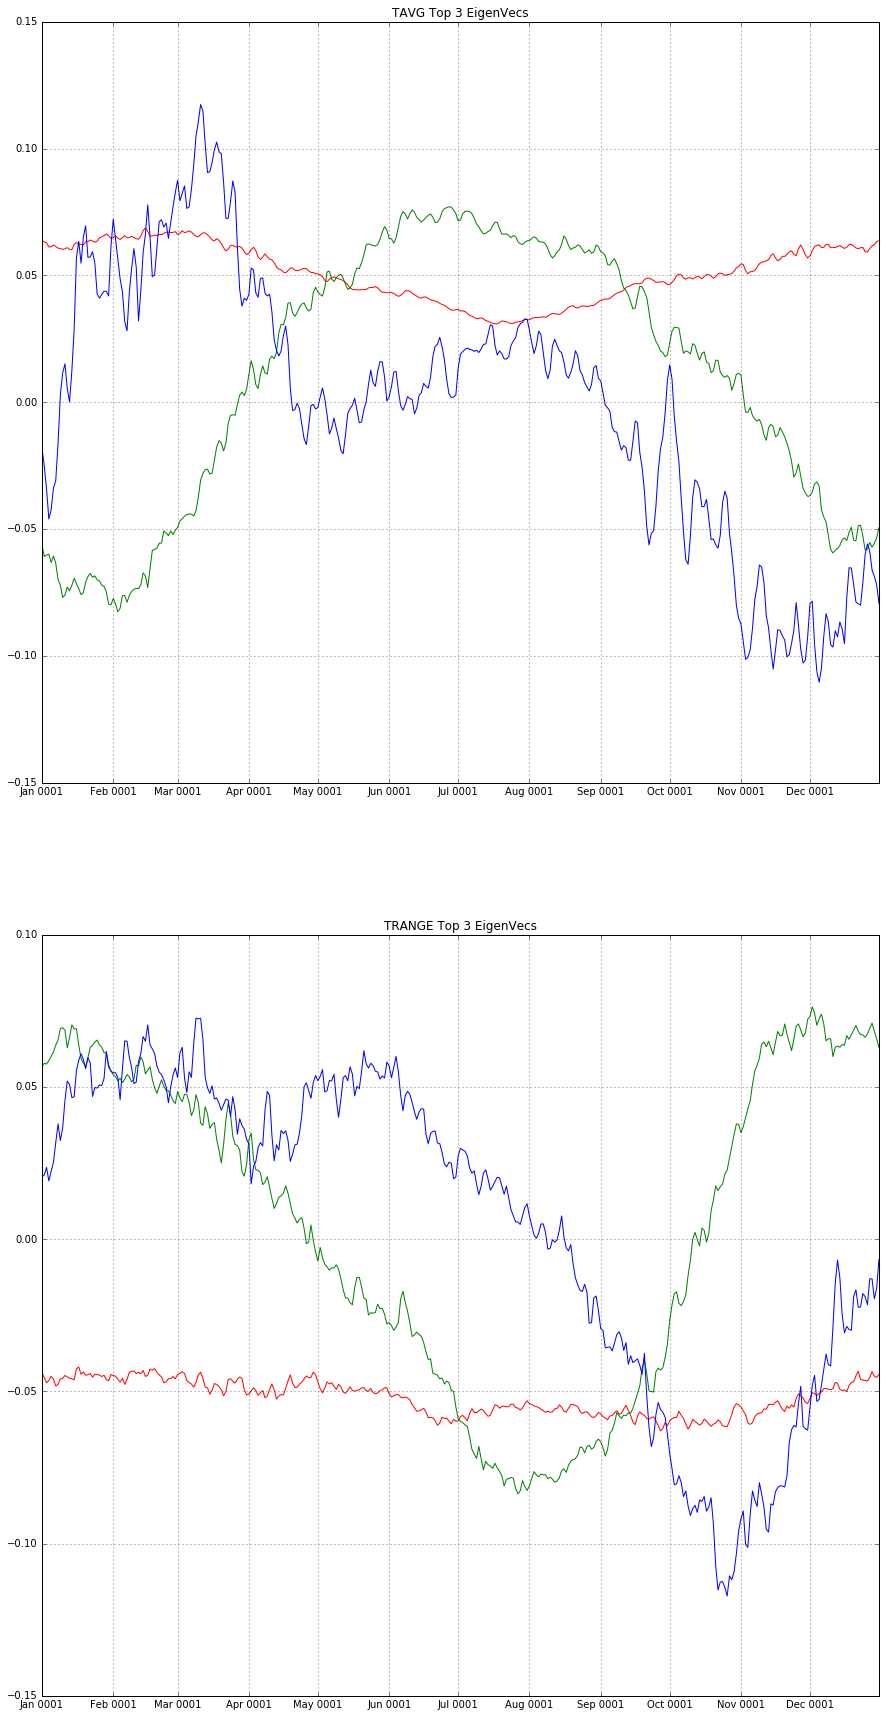

In [40]:
figure(figsize=(15,30))
col={0:'r',1:'g',2:'b'}
offset=1
for meas in STAT.keys():
    subplot(2,1,offset)
    offset+=1
    f=[[] for t in range(3)]
    for i in xrange(3):
        for k in xrange(365):
            f[i].append(STAT[meas]['eigvec'][k][i])
        YearlyPlots(f[i],c=col[i])
    title(meas + ' Top 3 EigenVecs')